In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

## Plot spectra

In [2]:
regions = [
    ('Co-60 Gamma Spectrum', './data/co60-2.csv'), 
    ('Cs-137 Gamma Spectrum', './data/cs137-2.csv'), 
    ('Na-22 Gamma Spectrum', './data/na22-2.csv')
]

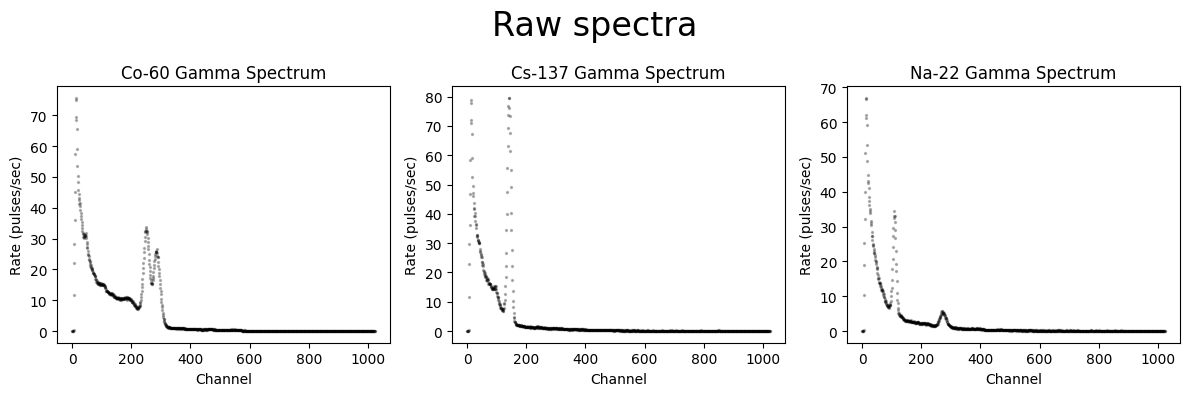

In [3]:
fig, axs = plt.subplots(1, len(regions), figsize=(4 * len(regions), 4))

for ax, (title, fname, *_) in zip(axs, regions):

    time, channels, counts = parse_usx_csv(fname)
    rate = counts / time
    
    ax.scatter(channels, rate, color='k', s=2, alpha=0.25)
    ax.set_title(title)
    ax.set_xlabel('Channel')
    ax.set_ylabel('Rate (pulses/sec)')

fig.suptitle('Raw spectra', fontsize=24)
plt.tight_layout()

fig.savefig('./figures/calibration_spectra.pdf')

## Spectra peaks

In [4]:
regions = [
    ('Co-60 Twin Gamma Peaks', './data/co60-2.csv', (200, 350)), 
    ('Cs-137 Gamma Peak', './data/cs137-2.csv', (100, 180)), 
    ('Na-22 Gamma Peak 1', './data/na22-2.csv', (80, 150)), 
    ('Na-22 Gamma Peak 2', './data/na22-2.csv', (200, 350))
]

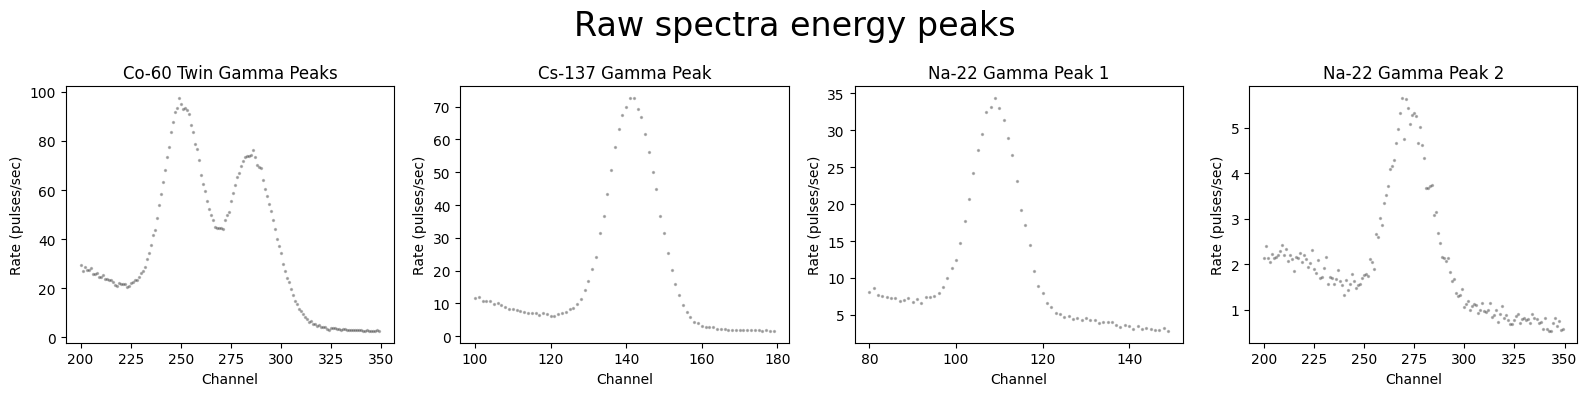

In [5]:
fig, axs = plt.subplots(1, len(regions), figsize=(4 * len(regions), 4))

for ax, (title, fname, (x0, x1)) in zip(axs, regions):
    
    fields, channels, counts = parse_usx_csv(fname)
    rate = counts / time
    
    ax.scatter(channels[x0:x1], rate[x0:x1], color='k', s=2, alpha=0.25)
    ax.set_title(title)
    ax.set_xlabel('Channel')
    ax.set_ylabel('Rate (pulses/sec)')

fig.suptitle('Raw spectra energy peaks', fontsize=24)
plt.tight_layout()

## Fit peaks

In [6]:
regions = [
    ('Co-60 Twin Gamma Peaks', './data/co60-2.csv', (200, 350), bigaussianlinear), 
    ('Cs-137 Gamma Peak', './data/cs137-2.csv', (100, 180), gaussianlinear), 
    ('Na-22 Gamma Peak 1', './data/na22-2.csv', (80, 150), gaussianlinear), 
    ('Na-22 Gamma Peak 2', './data/na22-2.csv', (200, 350), gaussianlinear)
]

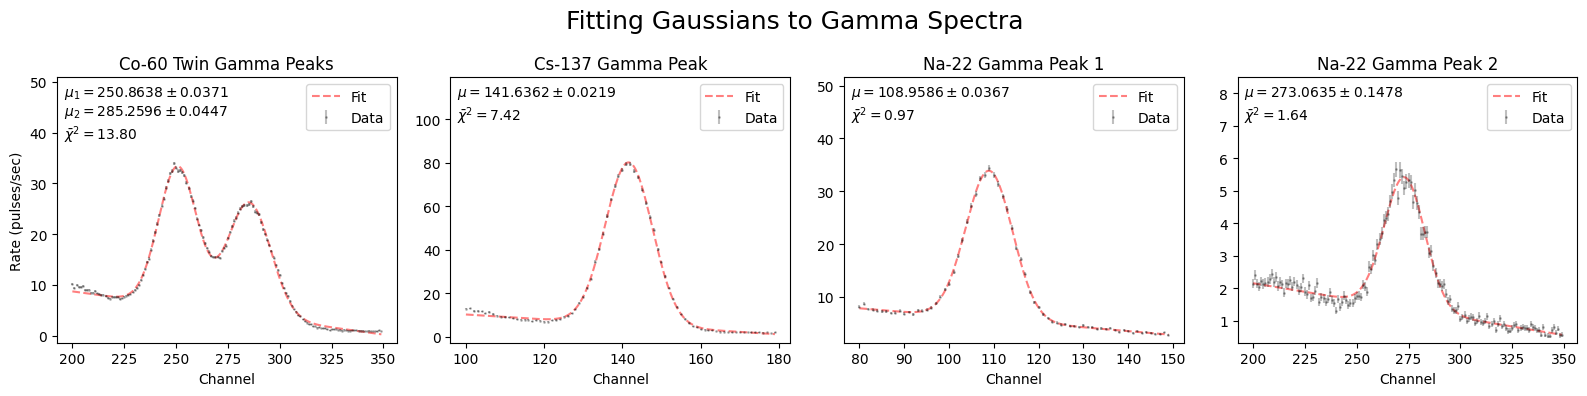

In [7]:
fig, axs = plt.subplots(1, len(regions), figsize=(4 * len(regions), 4))
means = []
means_err = []

for ax, (title, fname, (x0, x1), function) in zip(axs, regions):
    
    # Load data
    
    time, channels, counts = parse_usx_csv(fname)
    rate = counts / time
    rate_err = np.sqrt((counts / time**2) + (counts**2 * 0.1**2 / time**4))

    x = channels[x0:x1]
    y = rate[x0:x1]
    y_err = rate_err[x0:x1]
    
    # Estimate initial parameters
    
    params_i = [
        0, y.min(), 
        (y.max() - y.min()) * 16, (x1 + x0)/2 - 16, (x1 - x0)/16, 
    ]
    if function == bigaussianlinear: 
        params_i += [(y.max() - y.min()) * 16, (x1 + x0)/2 + 16, (x1 - x0)/16]
        
    # Fit curve
    
    params, params_err, chisq, dof = data_fit(
        params_i, function, 
        x, y, y_err
    )
    
    means.append(params[3])
    means_err.append(params_err[3])
    if function == bigaussianlinear:
        means.append(params[6])
        means_err.append(params_err[6])
    
    # Plot data
    
    linspace = np.linspace(x.min(), x.max(), num=1000)
    ax.plot(
        linspace, function(params, linspace), 
        color='r', linestyle='dashed', alpha=0.5, 
        label='Fit'
    )
    #if function == bigaussianlinear:
    #    ax.plot(linspace, gaussianlinear(np.concatenate([params[:2], params[2:5]]), linspace), color='r', linestyle='dashed', alpha=0.25)
    #    ax.plot(linspace, gaussianlinear(np.concatenate([params[:2], params[5:]]), linspace), color='r', linestyle='dashed', alpha=0.25)
    
    ax.set_ylim(None, y.max() * 1.25)
    ax.errorbar(
        x, y, yerr=y_err, 
        fmt='k.', markersize=2, alpha=0.25, 
        label='Data'
    )
    ax.set_title(title)
    ax.set_xlabel('Channel')
    ax.set_ylim(None, y.max() * 1.5)
    
    txt = ''
    if function == bigaussianlinear:
        txt += f'$\mu_1 = {params[3]:.4f} \\pm {params_err[3]:.4f}$ \n'
        txt += f'$\mu_2 = {params[6]:.4f} \\pm {params_err[6]:.4f}$ \n'
    else:
        txt += f'$\mu = {params[3]:.4f} \\pm {params_err[3]:.4f}$ \n'
    txt += '$\\bar{\\chi}^2 = ' + f'{chisq/dof:.2f}$'
    ax.text(0.02, 0.975, txt, transform=ax.transAxes , fontsize=10, va='top')
    ax.legend()

means = np.array(means)
means_err = np.array(means_err)

axs[0].set_ylabel('Rate (pulses/sec)')

fig.suptitle('Fitting Gaussians to Gamma Spectra', fontsize=18)
plt.tight_layout()
fig.savefig('./figures/calibration_fits.pdf')

## Fitting peak means

In [8]:
energies = [1173, 1333, 662, 511, 1275]

Params:  [4.66402766 2.22976949]
Params Error:  [0.00618106 1.384337  ]


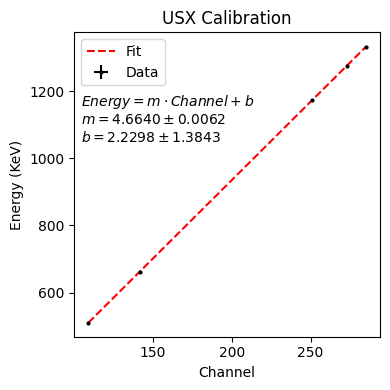

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))

params_i = [1, 0]
params, params_err, chisq, dof = data_fit(
    params_i, linear, 
    means, energies, np.ones_like(energies)
)
print('Params: ', params)
print('Params Error: ', params_err)

ax.errorbar(
    x=means, xerr=means_err, 
    y=energies, yerr=np.ones_like(energies), 
    fmt='k.', markersize=4, 
    label='Data'
)

linspace = np.linspace(min(means), max(means), 100)
curve = linear(params, linspace)
ax.plot(linspace, curve, color='r', linestyle='dashed', label='Fit')

txt = ''
txt += '$Energy = m \cdot Channel + b$ \n'
txt += f'$m = {params[0]:.4f} \\pm {params_err[0]:.4f}$ \n'
txt += f'$b = {params[1]:.4f} \\pm {params_err[1]:.4f}$ \n'
ax.text(0.02, 0.8, txt, transform=ax.transAxes , fontsize=10, va='top')

ax.set_xlabel('Channel')
ax.set_ylabel('Energy (KeV)')
ax.set_title('USX Calibration')
ax.legend()
plt.tight_layout()
fig.savefig('./figures/calibration.pdf')

Params:  [ 0.21417424 -0.25559726]
Params Error:  [5.31102486e-05 4.59760639e-02]


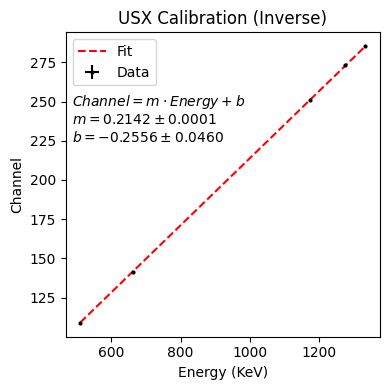

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))

params_i = [1, 0]
params, params_err, chisq, dof = data_fit(
    params_i, linear, 
    np.array(energies), means, means_err
)
print('Params: ', params)
print('Params Error: ', params_err)

ax.errorbar(
    x=energies, xerr=np.ones_like(energies), 
    y=means, yerr=means_err, 
    fmt='k.', markersize=4, 
    label='Data'
)

linspace = np.linspace(min(energies), max(energies), 100)
curve = linear(params, linspace)
ax.plot(linspace, curve, color='r', linestyle='dashed', label='Fit')

txt = ''
txt += '$Channel = m \cdot Energy + b$ \n'
txt += f'$m = {params[0]:.4f} \\pm {params_err[0]:.4f}$ \n'
txt += f'$b = {params[1]:.4f} \\pm {params_err[1]:.4f}$ \n'
ax.text(0.02, 0.8, txt, transform=ax.transAxes , fontsize=10, va='top')

ax.set_ylabel('Channel')
ax.set_xlabel('Energy (KeV)')
ax.set_title('USX Calibration (Inverse)')
ax.legend()
plt.tight_layout()
fig.savefig('./figures/calibration_inverse.pdf')